In [1]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# ------------------------------------------------
# 1. Helper Functions for Data Loading
# ------------------------------------------------
def load_pickle_file(file_path):
    """
    Loads a pickle file.
    Args:
        file_path (str): Path to the pickle file.
    Returns:
        Object stored in the pickle.
    """
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    return data

def load_sign_names(csv_path):
    """
    Loads sign names from a CSV file and creates a mapping dictionary.
    Assumes the CSV has columns 'ClassId' and 'SignName'.

    Args:
        csv_path (str): Path to the CSV file.
    Returns:
        dict: Mapping from class ID to sign name.
    """
    df = pd.read_csv(csv_path)
    sign_mapping = dict(zip(df['ClassId'], df['SignName']))
    return sign_mapping

In [3]:
# ------------------------------------------------
# 2. Load the Sign Names Mapping
# ------------------------------------------------
sign_mapping = load_sign_names('C:/Users/ahpuh/Desktop/Tsetlin_Traffic_Sign/signname.csv')
print("Sign Names Mapping:")
for cid, name in sign_mapping.items():
    print(f"Class {cid}: {name}")

Sign Names Mapping:
Class 0: Speed limit (20km/h)
Class 1: Speed limit (30km/h)
Class 2: Speed limit (50km/h)
Class 3: Speed limit (60km/h)
Class 4: Speed limit (70km/h)
Class 5: Speed limit (80km/h)
Class 6: End of speed limit (80km/h)
Class 7: Speed limit (100km/h)
Class 8: Speed limit (120km/h)
Class 9: No passing
Class 10: No passing for vehicles over 3.5 metric tons
Class 11: Right-of-way at the next intersection
Class 12: Priority road
Class 13: Yield
Class 14: Stop
Class 15: No vehicles
Class 16: Vehicles over 3.5 metric tons prohibited
Class 17: No entry
Class 18: General caution
Class 19: Dangerous curve to the left
Class 20: Dangerous curve to the right
Class 21: Double curve
Class 22: Bumpy road
Class 23: Slippery road
Class 24: Road narrows on the right
Class 25: Road work
Class 26: Traffic signals
Class 27: Pedestrians
Class 28: Children crossing
Class 29: Bicycles crossing
Class 30: Beware of ice/snow
Class 31: Wild animals crossing
Class 32: End of all speed and passing 

In [4]:
# 3. Load the Datasets from Pickle Files
# ------------------------------------------------
train_data = load_pickle_file('C:/Users/ahpuh/Desktop/Tsetlin_Traffic_Sign/train.p')
valid_data = load_pickle_file('C:/Users/ahpuh/Desktop/Tsetlin_Traffic_Sign/valid.p')
test_data  = load_pickle_file('C:/Users/ahpuh/Desktop/Tsetlin_Traffic_Sign/test.p')

# Extract features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test,  y_test  = test_data['features'],  test_data['labels']

print("\nDataset Shapes:")
print(f"Train: features {np.array(X_train).shape}, labels {np.array(y_train).shape}")
print(f"Validation: features {np.array(X_valid).shape}, labels {np.array(y_valid).shape}")
print(f"Test: features {np.array(X_test).shape}, labels {np.array(y_test).shape}")


Dataset Shapes:
Train: features (34799, 32, 32, 3), labels (34799,)
Validation: features (4410, 32, 32, 3), labels (4410,)
Test: features (12630, 32, 32, 3), labels (12630,)


In [5]:
# ------------------------------------------------
# 4. Preprocess the Images
# ------------------------------------------------
def preprocess_images(images, to_gray=True, binarize=True, threshold=128):
    """
    Converts images to grayscale (if needed), flattens them, and binarizes pixel values.

    Args:
        images (list or np.array): List/array of images.
        to_gray (bool): Convert color images to grayscale if True.
        binarize (bool): Convert pixel values to binary.
        threshold (int): Threshold for binarization.

    Returns:
        np.array: Array of processed images.
    """
    processed = []
    for img in images:
        # If image is in color (3 channels) and to_gray is True, convert it.
        if to_gray and len(img.shape) == 3 and img.shape[-1] == 3:
            # OpenCV assumes images are in BGR, but sometimes data is in RGB.
            # You might need to adjust if necessary.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Flatten the image to a 1D array.
        img_flat = img.flatten()
        if binarize:
            # Binarize the pixel values (assumes pixel values are in [0, 255])
            img_flat = (img_flat > threshold).astype(np.uint8)
        processed.append(img_flat)
    return np.array(processed)

X_train_proc = preprocess_images(X_train)
X_valid_proc = preprocess_images(X_valid)
X_test_proc  = preprocess_images(X_test)

print("\nProcessed Data Shapes:")
print("Train:", X_train_proc.shape)
print("Validation:", X_valid_proc.shape)
print("Test:", X_test_proc.shape)


Processed Data Shapes:
Train: (34799, 1024)
Validation: (4410, 1024)
Test: (12630, 1024)


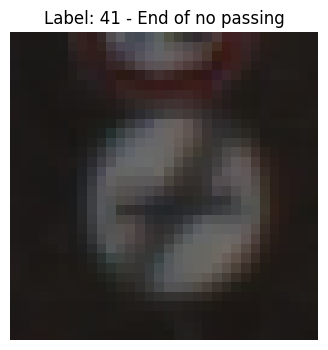

In [6]:
# ------------------------------------------------
# 5. (Optional) Visualize a Sample Image
# ------------------------------------------------
sample_idx = 0  # Change index to inspect other samples
sample_img = X_train[sample_idx]
sample_label = y_train[sample_idx]
plt.figure(figsize=(4, 4))
if len(sample_img.shape) == 2:
    plt.imshow(sample_img, cmap='gray')
else:
    plt.imshow(sample_img)
plt.title(f"Label: {sample_label} - {sign_mapping.get(sample_label, 'Unknown')}")
plt.axis('off')
plt.show()

In [8]:
import cv2 as cv
import numpy as np
from tmu.models.classification.vanilla_classifier import TMClassifier

def preprocess_images(images, method='adaptive_gaussian'):
    """
    Preprocess images using adaptive Gaussian thresholding.
    
    Parameters:
      images: iterable of images (NumPy arrays)
      method: thresholding method ('adaptive_gaussian' or 'simple')
      
    Returns:
      Numpy array of preprocessed (binarized) images.
    """
    processed_images = []
    for img in images:
        # Convert to grayscale if image is colored.
        if len(img.shape) > 2:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Ensure the image is in 8-bit format.
        img = img.astype(np.uint8)
        
        if method == 'adaptive_gaussian':
            # Apply adaptive Gaussian thresholding.
            thresh_img = cv.adaptiveThreshold(img, 1, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              cv.THRESH_BINARY, 11, 2)
        else:
            # Use a simple binary threshold as an alternative.
            _, thresh_img = cv.threshold(img, 127, 1, cv.THRESH_BINARY)
            
        processed_images.append(thresh_img)
    return np.array(processed_images)

# -------------------------------
# Preprocess the Training and Validation Images
# -------------------------------
# Assume X_train and X_valid are your original image datasets.
X_train_proc = preprocess_images(X_train, method='adaptive_gaussian')
X_valid_proc = preprocess_images(X_valid, method='adaptive_gaussian')

# Flatten images to create a 1D feature vector for each sample.
X_train_proc = X_train_proc.reshape((X_train_proc.shape[0], -1))
X_valid_proc = X_valid_proc.reshape((X_valid_proc.shape[0], -1))

# Convert data to uint32 as required by TMClassifier.
X_train_proc = X_train_proc.astype(np.uint32)
X_valid_proc = X_valid_proc.astype(np.uint32)
y_train = y_train.astype(np.uint32)
y_valid = y_valid.astype(np.uint32)

# -------------------------------
# Initialize and Train the Tsetlin Machine
# -------------------------------
tm = TMClassifier(
    number_of_clauses=100,
    T=15, 
    s=3.9,
    clause_drop_p=0.0
)

epochs = 50  # Adjust number of epochs as needed
print("\nTraining Tsetlin Machine...")
for epoch in range(epochs):
    tm.fit(X_train_proc, y_train, epochs=1)
    train_pred = tm.predict(X_train_proc)
    valid_pred = tm.predict(X_valid_proc)
    train_acc = np.mean(train_pred == y_train) * 100
    valid_acc = np.mean(valid_pred == y_valid) * 100
    print(f"Epoch {epoch+1:2d}/{epochs} - Train Accuracy: {train_acc:5.2f}% | Validation Accuracy: {valid_acc:5.2f}%")




Training Tsetlin Machine...
Epoch  1/50 - Train Accuracy: 76.26% | Validation Accuracy: 68.55%
Epoch  2/50 - Train Accuracy: 83.40% | Validation Accuracy: 75.42%
Epoch  3/50 - Train Accuracy: 86.31% | Validation Accuracy: 78.37%
Epoch  4/50 - Train Accuracy: 86.99% | Validation Accuracy: 78.82%
Epoch  5/50 - Train Accuracy: 88.69% | Validation Accuracy: 81.07%
Epoch  6/50 - Train Accuracy: 89.50% | Validation Accuracy: 81.16%
Epoch  7/50 - Train Accuracy: 90.22% | Validation Accuracy: 82.88%
Epoch  8/50 - Train Accuracy: 91.26% | Validation Accuracy: 84.29%
Epoch  9/50 - Train Accuracy: 90.68% | Validation Accuracy: 82.77%
Epoch 10/50 - Train Accuracy: 91.36% | Validation Accuracy: 83.97%
Epoch 11/50 - Train Accuracy: 91.83% | Validation Accuracy: 84.35%
Epoch 12/50 - Train Accuracy: 92.17% | Validation Accuracy: 84.76%
Epoch 13/50 - Train Accuracy: 92.13% | Validation Accuracy: 84.35%
Epoch 14/50 - Train Accuracy: 92.64% | Validation Accuracy: 85.56%
Epoch 15/50 - Train Accuracy: 92.

In [11]:
# -------------------------------
# Evaluate the Tsetlin Machine on the Test Set
# -------------------------------
# Assume X_test and y_test are your test dataset.
X_test_proc = preprocess_images(X_test, method='adaptive_gaussian')
X_test_proc = X_test_proc.reshape((X_test_proc.shape[0], -1))
X_test_proc = X_test_proc.astype(np.uint32)
y_test = y_test.astype(np.uint32)

test_pred = tm.predict(X_test_proc)
test_acc = np.mean(test_pred == y_test) * 100
print(f"\nTest Accuracy: {test_acc:5.2f}%")


Test Accuracy: 84.75%


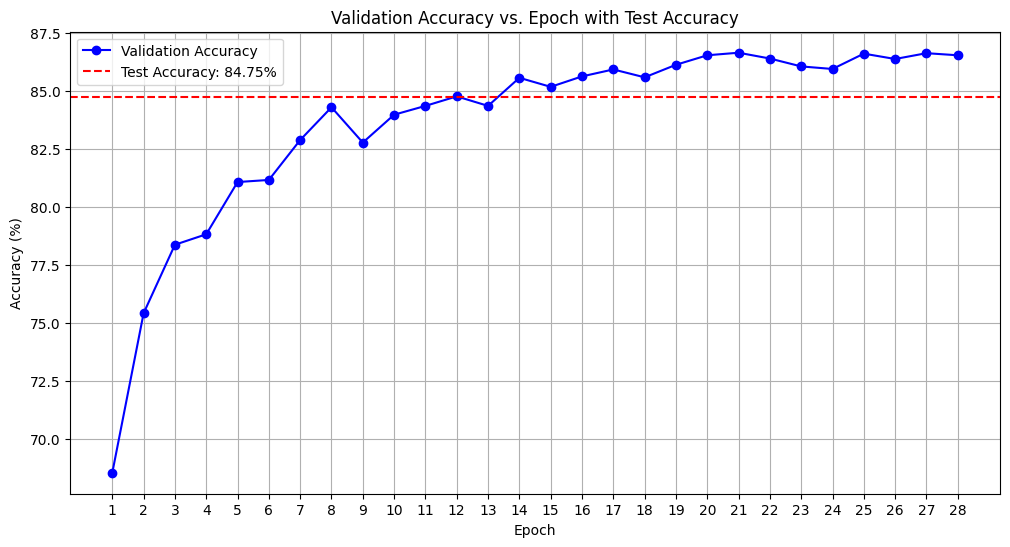

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Validation accuracies from the provided output
validation_accuracies = [
    68.55, 75.42, 78.37, 78.82, 81.07, 81.16, 82.88, 84.29, 82.77, 83.97,
    84.35, 84.76, 84.35, 85.56, 85.17, 85.62, 85.92, 85.58, 86.12, 86.53,
    86.64, 86.39, 86.05, 85.94, 86.60, 86.37, 86.62, 86.53
]

# Test accuracy
test_accuracy = 84.75

# Epoch numbers
epochs = np.arange(1, len(validation_accuracies) + 1)

# Plotting the validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, validation_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')

# Adding a horizontal line for test accuracy
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy: {test_accuracy:.2f}%')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy vs. Epoch with Test Accuracy')
plt.xticks(epochs)  # Show all epoch numbers
plt.grid(True)
plt.legend()

# Display the plot
plt.show()